In [70]:
import pandas as pd
import numpy as np
import pmdarima as pm
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

plt.style.use('bmh')
%matplotlib inline

# Reading Dataframes

In [71]:
data=pd.read_excel("data.xlsx",engine="openpyxl")
data.head()

,Date,Petrol (USD),Diesel (USD),Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,2003-06-09 00:00:00,74.590284,76.773394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-06-16 00:00:00,74.469143,76.689054,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-06-23 00:00:00,74.423566,76.620546,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-06-30 00:00:00,74.352421,76.505260,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-07-07 00:00:00,74.283737,76.457376,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Dropping irrelevent columns

In [72]:
data.drop(columns=["Unnamed: 3","Unnamed: 4","Unnamed: 5","Unnamed: 6","Unnamed: 7","Unnamed: 8","Unnamed: 9","Diesel (USD)"],axis=1,inplace=True)

In [73]:
data.head()

,Date,Petrol (USD)
0,2003-06-09 00:00:00,74.590284
1,2003-06-16 00:00:00,74.469143
2,2003-06-23 00:00:00,74.423566
3,2003-06-30 00:00:00,74.352421
4,2003-07-07 00:00:00,74.283737


# Handling Nan Values

In [74]:
data.isnull().any()

Date            True
Petrol (USD)    True
dtype: bool

In [75]:
data.dropna(axis=0, inplace=True)

In [76]:
data.isnull().any()

Date            False
Petrol (USD)    False
dtype: bool

In [77]:
data

,Date,Petrol (USD)
0,2003-06-09 00:00:00,74.590284
1,2003-06-16 00:00:00,74.469143
2,2003-06-23 00:00:00,74.423566
3,2003-06-30 00:00:00,74.352421
4,2003-07-07 00:00:00,74.283737
...,...,...
876,2020-03-23 00:00:00,119.644504
877,2020-03-30 00:00:00,112.452709
878,2020-04-06 00:00:00,110.234797
879,2020-04-13 00:00:00,109.265819


# Date reindex

In [78]:
data.set_index('Date', inplace=True)

In [79]:
data

,Petrol (USD)
Date,
2003-06-09,74.590284
2003-06-16,74.469143
2003-06-23,74.423566
2003-06-30,74.352421
2003-07-07,74.283737
...,...
2020-03-23,119.644504
2020-03-30,112.452709
2020-04-06,110.234797


# Plotting Petrol Prices

<AxesSubplot:xlabel='Date'>

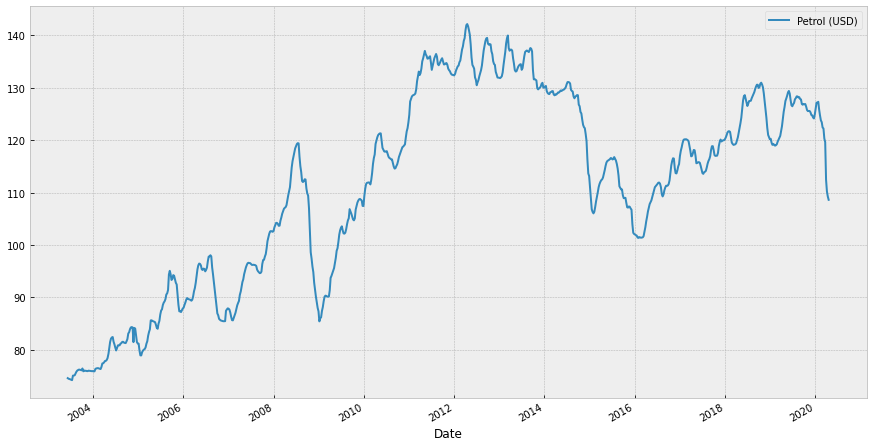

In [80]:
data.plot(figsize=(15,8))

<AxesSubplot:xlabel='Date'>

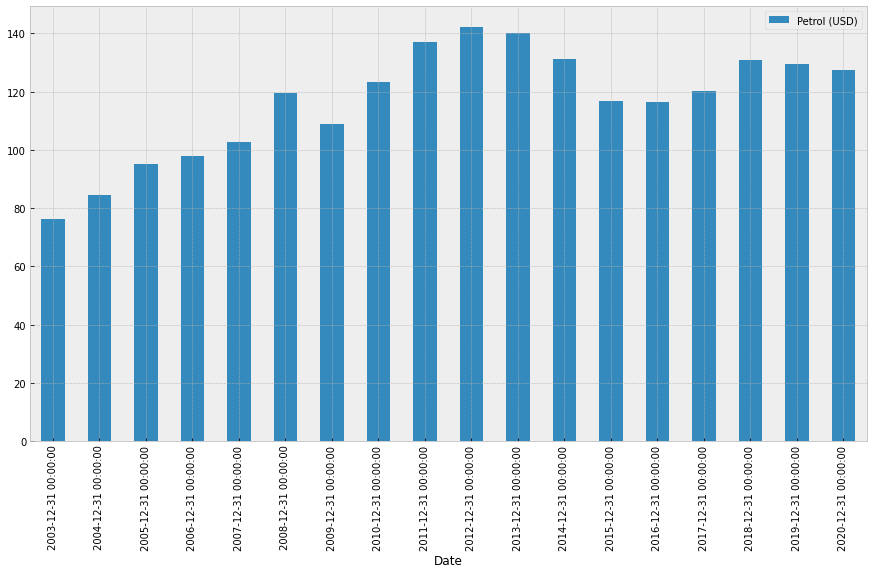

In [81]:
data.resample(rule="Y").max().plot(figsize=(15,8),kind="bar")

# Stationary Check

In [82]:
# By Dickey Fuller test

def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [83]:
def plotting(timeseries):
    
    rolmean=timeseries.rolling(window=12).mean()
    rolstd=timeseries.rolling(window=12).std()
    
    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries, color='red', label='Actual')
    mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

ADF Statistics: -2.26137597345439
p- value: 0.18472762657497221
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


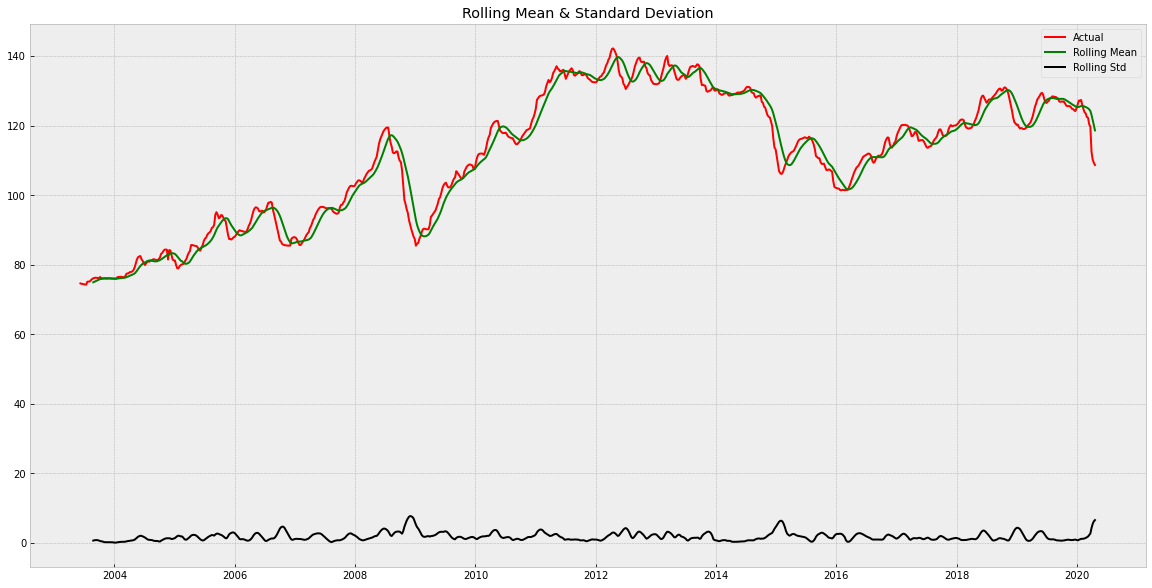

In [84]:
adf_test(data)
plotting(data)


# Converting Non-Stationary to stationary data

In [85]:
data_log = np.log(data)

<AxesSubplot:xlabel='Date'>

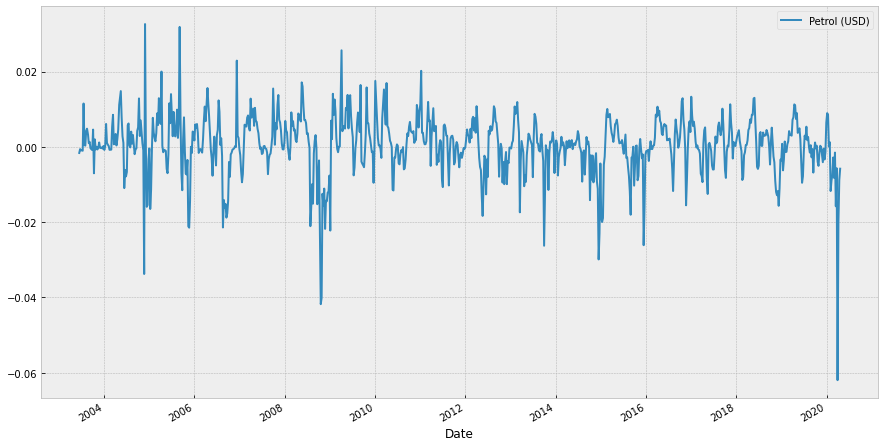

In [86]:
# We will convert non stationary to stationary by Log Transfomration
data_log_shift = data_log.shift()
data_log_shift=data_log - data_log_shift
data_log_shift.dropna(inplace = True)
data_log_shift.plot(figsize=(15,8))

In [87]:
data_log_shift.head()

,Petrol (USD)
Date,
2003-06-16,-0.001625
2003-06-23,-0.000612
2003-06-30,-0.000956
2003-07-07,-0.000924
2003-07-14,-0.001039


ADF Statistics: -7.974522462120352
p- value: 2.7248526340499035e-12
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


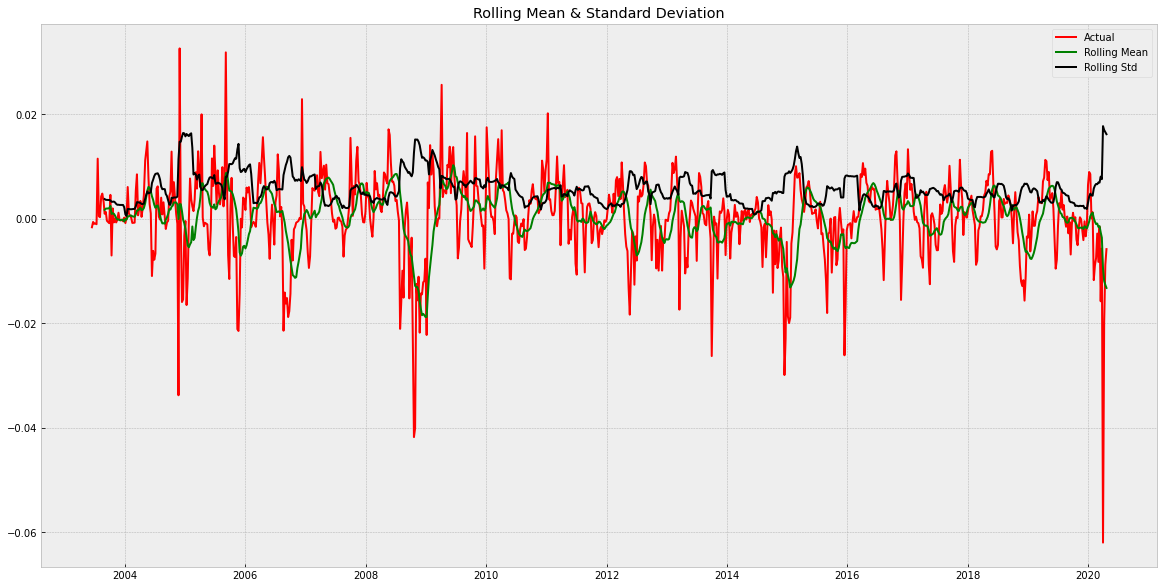

In [88]:
# Now again checking stationary
adf_test(data_log_shift)
plotting(data_log_shift)

# Decomposition of Data

In [89]:
decomposed=seasonal_decompose(x=data_log["Petrol (USD)"], model='multiplicative',freq=30)

C:\Users\Alee\Downloads\Forecasting_WeeklyFuelPrice\env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='Date'>

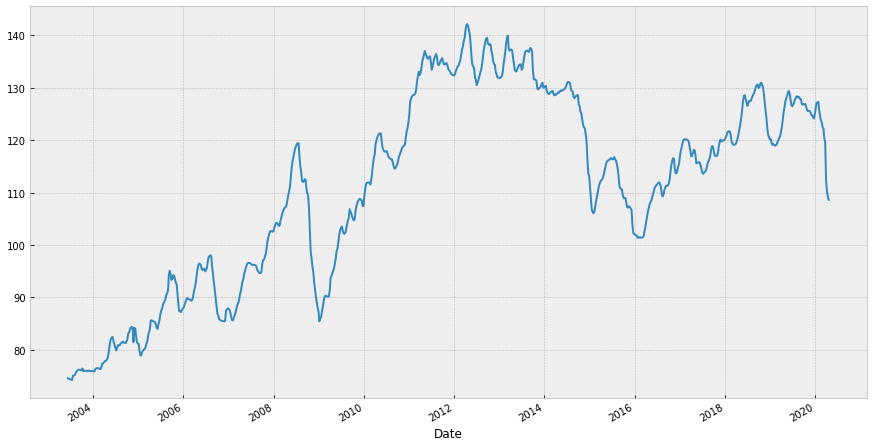

In [90]:
#original
data["Petrol (USD)"].plot(figsize=(15,8))

<AxesSubplot:xlabel='Date'>

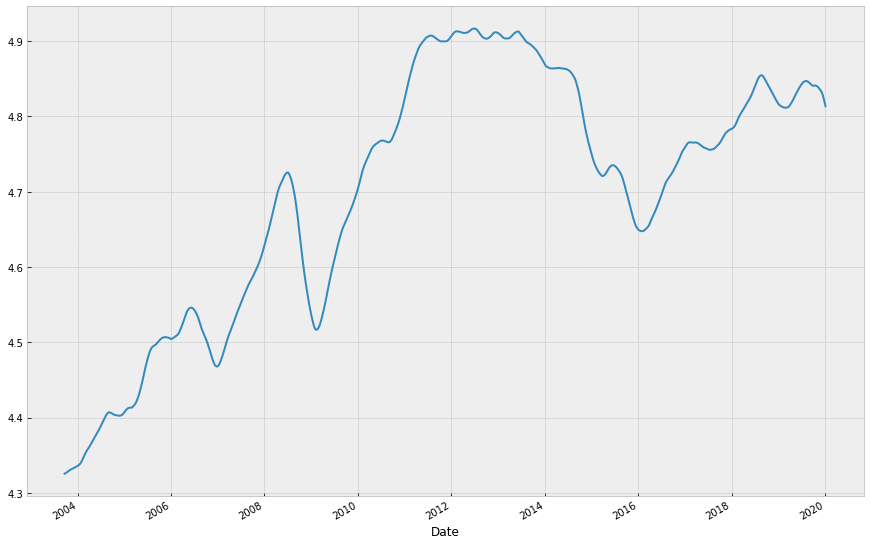

In [91]:
#trend
decomposed.trend.plot(figsize=(15,10))

<AxesSubplot:xlabel='Date'>

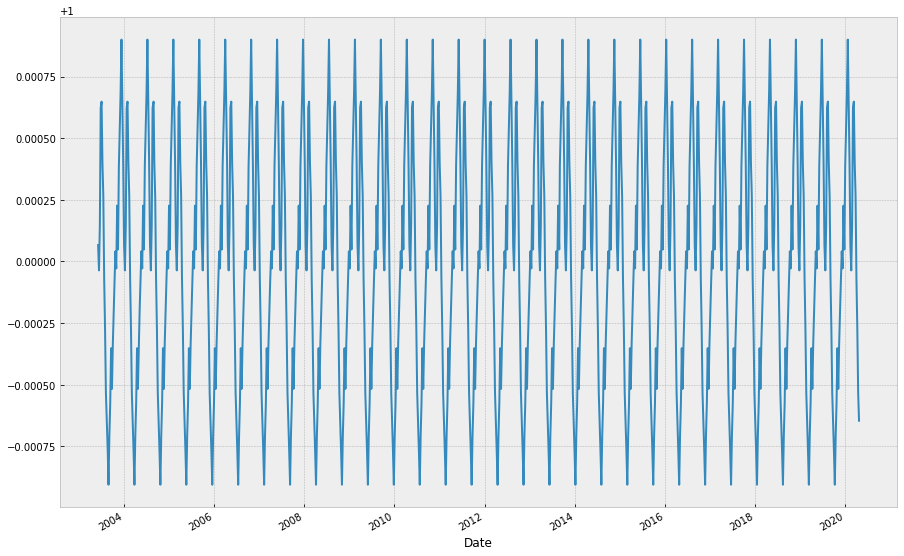

In [92]:
#seasonality
decomposed.seasonal.plot(figsize=(15,10))

<AxesSubplot:xlabel='Date'>

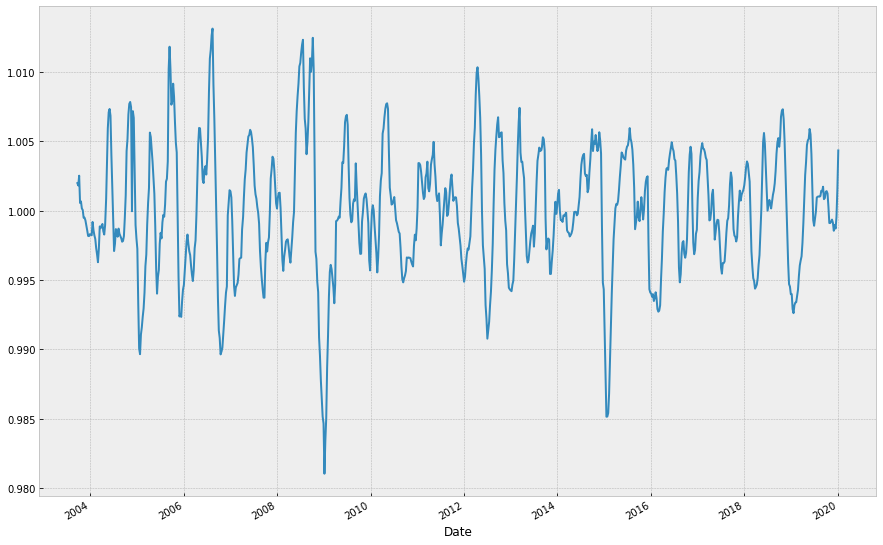

In [93]:
#Noise
decomposed.resid.plot(figsize=(15,10))

# Spliting data into test and train

In [94]:
# We split our dataset to be able to evaluate our models
data_log.dropna(inplace=True)
resultsDict = {}
predictionsDict = {}

split_date = '2016-01-01'
df_training = data_log.loc[data_log.index <= split_date]
df_test = data_log.loc[data_log.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

656 days of training data 
 225 days of testing data 


# ARIMA

In [95]:
# building the model

autoModel = pm.auto_arima(data_log['Petrol (USD)'], trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(data_log['Petrol (USD)'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6454.260, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6039.563, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6453.705, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6316.368, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6038.931, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6456.259, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6416.207, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6458.213, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6456.270, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6457.872, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6459.751, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-6316.702, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6455.117, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-6457.833, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

C:\Users\Alee\Downloads\Forecasting_WeeklyFuelPrice\env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Alee\Downloads\Forecasting_WeeklyFuelPrice\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A da

plotting ARIMA model


C:\Users\Alee\Downloads\Forecasting_WeeklyFuelPrice\env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


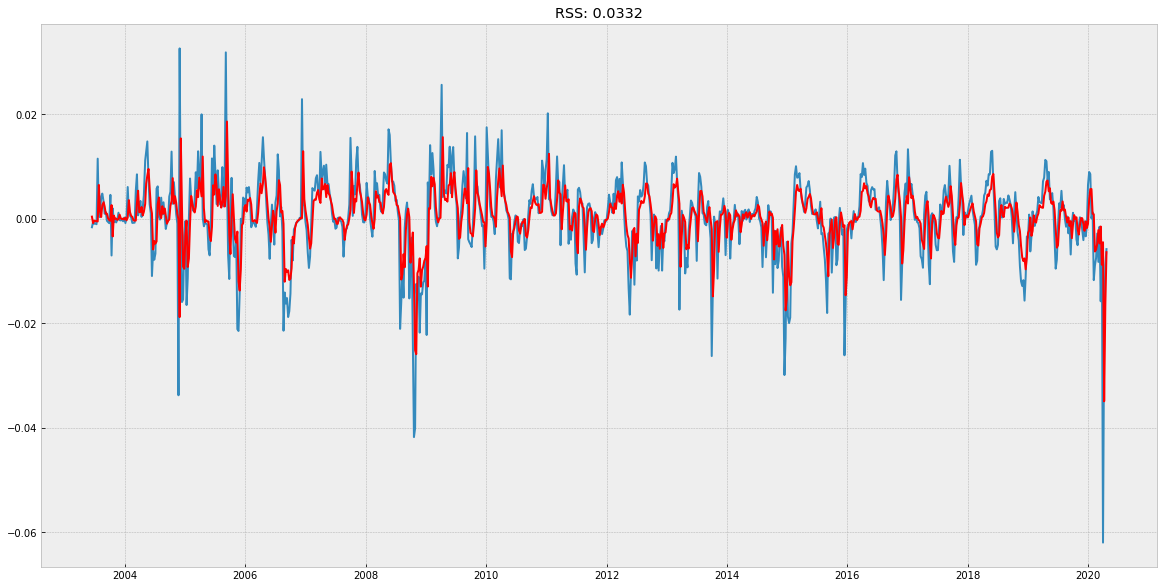

In [96]:
plt.figure(figsize=(20,10))
model=ARIMA(data_log, order=(2,1,2))
results=model.fit(disp=-1)
plt.plot(data_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-data_log_shift['Petrol (USD)'])**2))
print('plotting ARIMA model')

In [97]:
predictions=pd.Series(results.fittedvalues, copy=True)
print(predictions.head())

Date
2003-06-16    0.000406
2003-06-23   -0.000840
2003-06-30   -0.000344
2003-07-07   -0.000447
2003-07-14   -0.000466
dtype: float64


In [98]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

Date
2003-06-16    0.000406
2003-06-23   -0.000435
2003-06-30   -0.000779
2003-07-07   -0.001226
2003-07-14   -0.001692
dtype: float64


In [99]:
predictions_log=pd.Series(data_log['Petrol (USD)'], index=data_log.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
predictions_log.head()

Date
2003-06-09    4.312010
2003-06-16    4.310791
2003-06-23    4.309338
2003-06-30    4.308037
2003-07-07    4.306666
dtype: float64

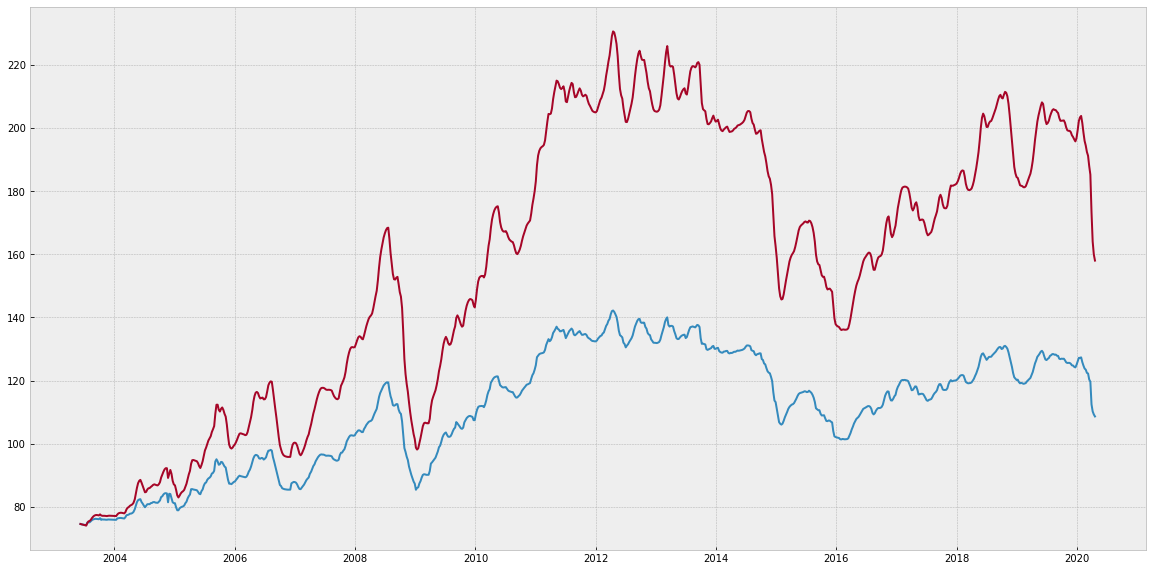

In [100]:
predictions_ARIMA=np.exp(predictions_log)
plt.figure(figsize=(20,10))
plt.plot(data)
plt.plot(predictions_ARIMA)

array([108.16925979, 107.88044773, 107.68298206, 107.56557757,
       107.49386907, 107.45948445, 107.44773352, 107.4535833 ,
       107.47056537, 107.4959148 , 107.52671505, 107.56151826,
       107.59898496, 107.63837814, 107.679074  , 107.72070398,
       107.76297458, 107.80570361, 107.84875193, 107.89203015,
       107.93547199, 107.97903381, 108.02268389, 108.06640103,
       108.11017002, 108.15398056, 108.19782535, 108.24169941,
       108.28559922, 108.32952239, 108.37346721, 108.41743254,
       108.46141756, 108.50542172, 108.54944463, 108.59348602,
       108.63754571, 108.68162358, 108.72571954, 108.76983354,
       108.81396554, 108.85811552, 108.90228345, 108.94646934,
       108.99067318, 109.03489498, 109.07913473, 109.12339243,
       109.1676681 , 109.21196173, 109.25627335, 109.30060294,
       109.34495051, 109.38931609, 109.43369966, 109.47810125,
       109.52252084, 109.56695847, 109.61141412, 109.65588781,
       109.70037954, 109.74488933, 109.78941718, 109.83

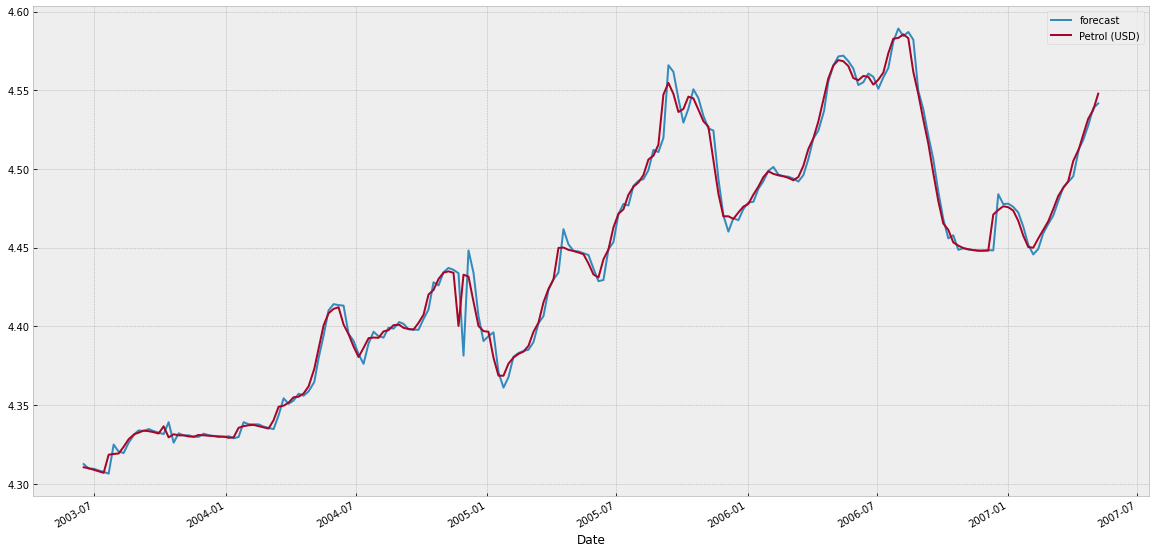

In [103]:
rcParams['figure.figsize']=20,10
results.plot_predict(1,204)
x=results.forecast(steps=120)
x[0]
np.exp(x[0])